<a href="https://colab.research.google.com/github/yoraoui/PingPong/blob/main/point_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! python -V
! pip3 install trimesh 
! pip3 install pyglet

Python 3.7.10
     |████████████████████████████████| 634kB 29.7MB/s 


In [ ]:
import pdb
import os
import glob
import trimesh
import trimesh.sample
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random as random

In [ ]:
# If using a GPU keep these lines to avoid CUDNN errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Testing Stuff in this cell, Not Relevant for the problem
from typing import NewType

PointCloud = NewType("PointCloud", np.ndarray)
print(PointCloud)

def get_point_cloud():
  return np.random.randint(1, 10, size = (1024, 3))

pcs = []
for i in range(10):
  pcs.append(get_point_cloud())

for pc in pcs:
 # print(pc.shape)
 # print(PointCloud(pc))
 pass

<function NewType.<locals>.new_type at 0x7f227a9ca290>


## Getting the data to local system

In [ ]:
import os

if not os.path.exists("ModelNet10.zip"):
  ! curl http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip -L -o ModelNet10.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  451M  100  451M    0     0  80.5M      0  0:00:05  0:00:05 --:--:-- 84.1M


In [ ]:
import os
if not os.path.exists("data/ModelNet10"):
  os.mkdir("data") 
  !unzip ModelNet10.zip -d ./data/

In [ ]:
!ls data/ModelNet10

bathtub  chair	dresser  night_stand  sofa   toilet
bed	 desk	monitor  README.txt   table


In [ ]:
data_folder = os.path.join(os.curdir, "data", "ModelNet10")
with open(os.path.join(data_folder, "README.txt")) as f:
  print(f.read())
  f.close()

This folder contains 10 categories of CAD models from the Princeton ModelNet dataset. 
This 10 categories are used in our paper for experiments.

File format:

1. The CAD models are saved as OFF file format [refer to http://segeval.cs.princeton.edu/public/off_format.html ]. 
2. You can open it in Meshlab http://meshlab.sourceforge.net
3. You can use the following function in Matlab to load the models:
http://vision.princeton.edu/pvt/RenderMe/RenderDepth/offLoader.m

Citation:

Please cite the following document if you use this dataset:
Z. Wu, S. Song, A. Khosla, X. Tang, and J. Xiao
3D ShapeNets for 2.5D Object Recognition and Next-Best-View Prediction
arXiv:1406.5670 [cs.CV]

Question or Bug?

Please contact with Jianxiong Xiao (xj [at] princeton [dot] edu)


## Reading and Visualising the data

In [ ]:
! export data_folder="./data/ModelNet10"

In [ ]:
DATA_DIR = data_folder
print(DATA_DIR)

./data/ModelNet10


In [ ]:
!ls $data_folder/bathtub/test

bathtub_0107.off  bathtub_0120.off  bathtub_0133.off  bathtub_0146.off
bathtub_0108.off  bathtub_0121.off  bathtub_0134.off  bathtub_0147.off
bathtub_0109.off  bathtub_0122.off  bathtub_0135.off  bathtub_0148.off
bathtub_0110.off  bathtub_0123.off  bathtub_0136.off  bathtub_0149.off
bathtub_0111.off  bathtub_0124.off  bathtub_0137.off  bathtub_0150.off
bathtub_0112.off  bathtub_0125.off  bathtub_0138.off  bathtub_0151.off
bathtub_0113.off  bathtub_0126.off  bathtub_0139.off  bathtub_0152.off
bathtub_0114.off  bathtub_0127.off  bathtub_0140.off  bathtub_0153.off
bathtub_0115.off  bathtub_0128.off  bathtub_0141.off  bathtub_0154.off
bathtub_0116.off  bathtub_0129.off  bathtub_0142.off  bathtub_0155.off
bathtub_0117.off  bathtub_0130.off  bathtub_0143.off  bathtub_0156.off
bathtub_0118.off  bathtub_0131.off  bathtub_0144.off
bathtub_0119.off  bathtub_0132.off  bathtub_0145.off


In [ ]:
num_points_per_cloud = 1024     # <- you can modify this number as needed

In [ ]:
cad_mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0010.off"))  # <- Set path to a .off file
#cad_mesh.show()

## Utils functions

In [ ]:
# Test Code
class_ids = {}
folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
for class_id, folder in enumerate(folders):
  print(os.path.basename(folder))
  class_ids[class_id] = os.path.basename(folder)
sub_folder = "train"
for f in folders:
  # train_folder = os.path.join(f, "train")
  # print(train_folder)
  # # print(os.listdir(train_folder))
  print(glob.glob(os.path.join(f, f"{sub_folder}/*.off")))

print(class_ids)

monitor
toilet
chair
sofa
night_stand
bed
desk
dresser
table
bathtub
['./data/ModelNet10/monitor/train/monitor_0074.off', './data/ModelNet10/monitor/train/monitor_0297.off', './data/ModelNet10/monitor/train/monitor_0416.off', './data/ModelNet10/monitor/train/monitor_0136.off', './data/ModelNet10/monitor/train/monitor_0066.off', './data/ModelNet10/monitor/train/monitor_0357.off', './data/ModelNet10/monitor/train/monitor_0268.off', './data/ModelNet10/monitor/train/monitor_0255.off', './data/ModelNet10/monitor/train/monitor_0291.off', './data/ModelNet10/monitor/train/monitor_0424.off', './data/ModelNet10/monitor/train/monitor_0086.off', './data/ModelNet10/monitor/train/monitor_0016.off', './data/ModelNet10/monitor/train/monitor_0143.off', './data/ModelNet10/monitor/train/monitor_0241.off', './data/ModelNet10/monitor/train/monitor_0011.off', './data/ModelNet10/monitor/train/monitor_0289.off', './data/ModelNet10/monitor/train/monitor_0216.off', './data/ModelNet10/monitor/train/monitor_0318.

In [ ]:

# function for getting point_cloud by passing cad mesh filepath
def mesh_file_2_pc(file_path, n_points):
  "function takes path to a cad file and returns point cloud (generated with n_points)"
  cad_mesh = trimesh.load(file_path)
  point_cloud_array = trimesh.sample.sample_surface(cad_mesh, n_points)[0]
  return point_cloud_array

In [ ]:
def test_dry_run():
  " to test extraction of all point clouds to list"

  def process_folders(folders, subFolder_type = "train"):
    "collecting all the point clouds in a folder into array"
    pcs = []  # array to hold all point clouds
    for f in folders:
      mesh_files = glob.glob(os.path.join(f, f"{subFolder_type}/*.off"))
      print(f"Getting point cloud for: \n {mesh_files}")
      for file in mesh_files[:2]:   
        # reading 2 files from each to keep the run short
        point_cloud = mesh_file_2_pc(file, 1024)
        pcs.append(point_cloud)

    return pcs

  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))
  pcs = process_folders(folders)
  for pc in pcs:
    print(pc.shape)
  
  return pcs

pcs = test_dry_run()

Getting point cloud for: 
 ['./data/ModelNet10/monitor/train/monitor_0074.off', './data/ModelNet10/monitor/train/monitor_0297.off', './data/ModelNet10/monitor/train/monitor_0416.off', './data/ModelNet10/monitor/train/monitor_0136.off', './data/ModelNet10/monitor/train/monitor_0066.off', './data/ModelNet10/monitor/train/monitor_0357.off', './data/ModelNet10/monitor/train/monitor_0268.off', './data/ModelNet10/monitor/train/monitor_0255.off', './data/ModelNet10/monitor/train/monitor_0291.off', './data/ModelNet10/monitor/train/monitor_0424.off', './data/ModelNet10/monitor/train/monitor_0086.off', './data/ModelNet10/monitor/train/monitor_0016.off', './data/ModelNet10/monitor/train/monitor_0143.off', './data/ModelNet10/monitor/train/monitor_0241.off', './data/ModelNet10/monitor/train/monitor_0011.off', './data/ModelNet10/monitor/train/monitor_0289.off', './data/ModelNet10/monitor/train/monitor_0216.off', './data/ModelNet10/monitor/train/monitor_0318.off', './data/ModelNet10/monitor/train/mon

In [ ]:
assert np.array(pcs).shape == (20, 1024, 3)

# 20 point cloud files with each of shape (1024, 3)

In [ ]:

def create_point_cloud_dataset(data_dir, num_points_per_cloud=1024):
    """
    Given the path to the ModelNet10 dataset, samples the models and creates point clouds
    :param data_dir: path to the ModelNet10 dataset
    :type data_dir: str
    :param num_points_per_cloud: number of points to sample per cloud. 1024, 2048....
    :type num_points_per_cloud: int
    :return: tuple of numpy array containing training and test point clouds, their corresponding labels and a list of
    class IDs
    :rtype: tuple
    """

    train_pc = []   # array of training point clouds
    test_pc = []    # array of test point clouds

    train_labels = []   # array of corresponding training labels
    test_labels = []    # array of corresponding test labels

    class_ids = {}   # list of class names

    # get all the folders except the readme file
    folders = glob.glob(os.path.join(data_dir, "[!README]*"))
    print(folders)
    for class_id, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))

        # Custom code here, get the name of the folder (class) and save it
        ##############################
        class_ids[class_id] = os.path.basename(folder)
        ##############################

        # get the files in the train folder
        train_files = glob.glob(os.path.join(folder, "train/*"))
        for f in train_files:
            # Custom Code Here
            ##################################
            pc = mesh_file_2_pc(f, num_points_per_cloud)
            train_pc.append(pc)
            train_labels.append(class_id)
            ###############################3
            
        # get the files in the test folder
        test_files = glob.glob(os.path.join(folder, "test/*"))
        for f in test_files:
            # Custom Code Here
            ##########################
            pc = mesh_file_2_pc(f, num_points_per_cloud)
            test_pc.append(pc) 
            test_labels.append(class_id)
            ########################
            

    return (np.array(train_pc), np.array(test_pc),
            np.array(train_labels), np.array(test_labels), class_ids)


In [ ]:

def visualize_cloud(point_cloud):
    """
    Utility function to visualize a point cloud
    :param point_cloud: input point cloud
    :type point_cloud: numpy array
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2])
    plt.show()


def add_noise_and_shuffle(point_cloud, label):
    """
    Adds noise to a point cloud and shuffles it
    :param point_cloud: input point cloud
    :type point_cloud: tensor
    :param label: corresponding label
    :type label: tensor
    :return: the processed point cloud and the label
    :rtype: tensors
    """
    dev_in_metres = 0.002   # <- change this value to change amount of noise
    # add noise to the points
    point_cloud += tf.random.uniform(point_cloud.shape, -dev_in_metres, dev_in_metres, dtype=tf.float64)
    # shuffle points
    point_cloud = tf.random.shuffle(point_cloud)
    return point_cloud, label

### Generating the point cloud for a geometry

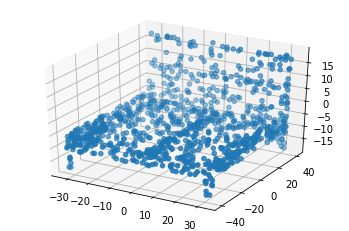

float64 (1024, 3)


In [ ]:
points = trimesh.sample.sample_surface(cad_mesh, 1024)[0]
# visualize the point cloud using matplotlib
visualize_cloud(points)
print(points.dtype, points.shape)


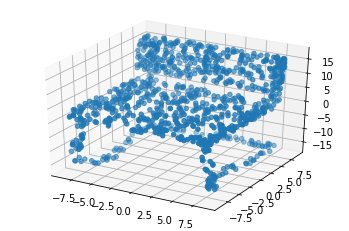

In [ ]:
def object_pc(category: str): 
  n = np.random.randint(1, 10)
  cad_mesh = trimesh.load(os.path.join(DATA_DIR, f"{category}/train/{category}_000{n}.off"))
  points = trimesh.sample.sample_surface(cad_mesh, 1024)[0]
  # visualize the point cloud using matplotlib
  visualize_cloud(points)

object_pc("chair")

### Generating point clouds from complete dataset

In [ ]:
num_points_per_cloud = 1024     # <- you can modify this number as needed
train_pc, test_pc, train_labels, test_labels, class_ids = create_point_cloud_dataset(DATA_DIR, num_points_per_cloud)

['./data/ModelNet10/monitor', './data/ModelNet10/toilet', './data/ModelNet10/chair', './data/ModelNet10/sofa', './data/ModelNet10/night_stand', './data/ModelNet10/bed', './data/ModelNet10/desk', './data/ModelNet10/dresser', './data/ModelNet10/table', './data/ModelNet10/bathtub']
processing class: monitor
processing class: toilet
processing class: chair
processing class: sofa
processing class: night_stand
processing class: bed
processing class: desk
processing class: dresser
processing class: table
processing class: bathtub


### Saving Point Cloud in pickle files 

In [ ]:
import pickle

# once loaded save the numpy arrays to pickle files to use later
pickle.dump(train_pc, open("trainpc.pkl", "wb"))
pickle.dump(test_pc, open("testpc.pkl", "wb"))
pickle.dump(train_labels, open("trainlabels.pkl", "wb"))
pickle.dump(test_labels, open("testlabels.pkl", "wb"))
pickle.dump(class_ids, open("class_ids.pkl", "wb"))

In [ ]:
ls

class_ids.pkl  ModelNet10.zip  testlabels.pkl  trainlabels.pkl
data/          sample_data/    testpc.pkl      trainpc.pkl


In [ ]:
# from google.colab import files

def download_files():
  "download files to avoid preprocessing again"
  for file in ["trainpc.pkl", "trainlabels.pkl", "testpc.pkl", "testlabels.pkl", "class_ids.pkl"]:
    files.download(file)

# download_files()

In [ ]:
# RUN THIS ONLY IF UPLOADING FILE FROM LOCAL SYSTEM 

from google.colab import files

def upload_files():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# upload_files()

# CAN START HERE IF POINT CLOUD IS ALREADY PROCESSED AND SAVED AS PICKLE FILES

### Getting the already saved point cloud arrays and labels

In [ ]:
ls

class_ids.pkl  testlabels.pkl  trainlabels.pkl
sample_data/   testpc.pkl      trainpc.pkl


In [ ]:
# load the data from pickle files if already present
import pickle 

def load_from_files():
  train_pc = pickle.load(open("trainpc.pkl", "rb"))
  train_labels = pickle.load(open("trainlabels.pkl", "rb"))
  test_pc = pickle.load(open("testpc.pkl", "rb"))
  test_labels = pickle.load(open("testlabels.pkl", "rb"))
  class_ids = pickle.load(open("class_ids.pkl", "rb"))

# load_from_files()

In [ ]:
# Glipse of the data that was generated in preprocessing
print(train_pc.shape)
print(train_pc[0])
print(train_labels.shape)
print(train_labels[0:3900: 100])
print(test_pc.shape)
print(test_labels.shape)
print(test_labels[0:900: 100])
print(class_ids)


(3991, 1024, 3)
[[-38.94665402 -62.25338741 -81.75196   ]
 [ -1.23607269  -4.33874335 -88.937     ]
 [-28.64168815  21.02058335 -84.21259   ]
 ...
 [ 17.57792005  -5.30152505 -84.21259   ]
 [-37.38186881 -55.63619471 -84.21259   ]
 [-22.99646421 -54.47316075 -79.29133   ]]
(3991,)
[0 0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 4 4 5 5 5 5 5 6 6 7 7 8 8
 8 8]
(908, 1024, 3)
(908,)
[0 1 2 3 4 5 6 7 8]
{0: 'monitor', 1: 'toilet', 2: 'chair', 3: 'sofa', 4: 'night_stand', 5: 'bed', 6: 'desk', 7: 'dresser', 8: 'table', 9: 'bathtub'}


### Generating scene with multiple objects for inputs to segmentation model

In [ ]:
# import pdb
import numpy as np
import pdb
import random
import pandas as pd
from tqdm import tqdm


def as_list(x):
    if type(x) is list:
        return x
    else:
        return [x]

def one_hot(scene_labels):
  # pdb.set_trace()
  " return [0, 1, 0, 1, 0, 0, 0, 0, 1, 0] for scene_labels = [8, 1, 3]"
  one_hot_array = np.zeros(10)
  for i in scene_labels:
    one_hot_array[i] = 1
  
  return one_hot_array

def get_tiled(label_onehot):
  tiled_labels = np.tile(label_onehot, (1024, 1))
  return tiled_labels

def pc_transform(pc):
  "takes a point cloud and transform"
  # [4, 4, 4] * [2.5, 2.5, 2.5].T = [10, 10, 10]

  # scaling and objects by say 2.6 times
  scaled_pcs = []
  factor = np.random.randint(1, 2) + np.random.randn()
  # factor = 1.
  scaling_factor = [factor, factor, factor]
  # print(f"scaling factor: {scaling_factor}")
  
  scaling_diag_array = np.diag(scaling_factor)
  scaled_pc = np.dot(pc, scaling_diag_array.T)
  # print(f"scaled point cloud shape: {scaled_pc.shape}")

  a = [[1, 3, 5], [2, 4, 6]]
  sf = np.diag([2, 2, 2])
  assert (np.dot(a, sf.T) == [[2, 6, 10], [4, 8, 12]]).all()

  assert scaled_pc.shape == (1024, 3), "scales_pcs dims mismatch issue"
  # for row in point_cloud_array:
  #   scaled_row   = np.dot(row, scaling_diag_array.T) # do np.dot(A, B)
  #   scaled_pcs.append(scaled_row)

  # translation
  translated_length = np.random.randint(-40, 40, size= (1, 3))
  translation_mat = np.tile(translated_length, (1024, 1))
  # print(f"translated_length : {translated_length }")
  translated_pc = np.add(scaled_pc,  translation_mat)

  assert translated_pc.shape == (1024, 3), "translated_pcs dims mismatch"

  # for row in scaled_pcs:
  #   print(f"point cloud row for")
  #   new_point_loc = row + translated_length
  #   print(f"new point loc: {new_point_loc}")
  #   translated_pcs.append(new_point_loc)
  
  return translated_pc

def get_random_index(grouped_idx_df):
  random.seed(123)
  df1 = grouped_idx_df.apply(np.random.choice)
  random_indexes = df1.sample(n=3, replace = False).tolist()
  return random_indexes

def generate_scenes(pc_array, label_array, n_scenes, n_objects):
  "this generates the scene from the point cloud given"
  scene_pc_array = []
  scene_label_array = []

  # n_records_in_pc = len(pc_array)
  # print("n_records_in_pc", n_records_in_pc)
  # l = list(range(n_records_in_pc))
  # random.seed(123)
  # random.shuffle(l)
  
  # generating groups of indexes with same label
  df = pd.DataFrame(label_array, columns = ["labels"])
  df["index"] = df.index
  grouped_idx_df = df.groupby("labels")["index"].apply(list)

  for i in tqdm(range(n_scenes)):
    "this look will run to create a scene"
    index_values  = get_random_index(grouped_idx_df) 
    # print("index_values", index_values)
    scene_pc = np.empty((0, 3))
    pointwise_labels = np.empty((0, 10))
    for j, idx in enumerate(index_values):
      "this loop will run to add objects to a single scene"
      # print("idx", idx)
      # print(pc_array[idx], "pc_array[idx]")
      #scene_pc.append(pc_array[idx]) # before adding an object in scece, transform it (scale it and translate)
      scene_pc = np.append(scene_pc, pc_transform(pc_array[idx]), axis = 0)
      pointwise_labels = np.append(pointwise_labels, get_tiled(one_hot(as_list(label_array[idx]))), axis= 0)
      # print(f"scene labels for scene {i}: {scene_label}")
    scene_pc_array.append(np.array(scene_pc))
    scene_label_array.append(np.array(pointwise_labels))

  return np.array(scene_pc_array), np.array(scene_label_array)
  # CTRL + M + L 

def segmentation_pc_gen(train_pc, train_labels, test_pc, test_labels):
  """
  Generates point cloud from segmentation problem 
  Input: list of point clouds [total_objects, 1024, 3]
  Output: list of point clouds where each point cloud is [2048, 3] => anything which has more thatn 2 objects will need to resample so the size is amaintained 
    2 objects in a scene => (2048, 3)
    4 objects in a scene => (4096, 3) => we need to resample from this so that overall point cloud size of (2048, 3) is maintained


  """
  N_TRAIN = 2000
  N_TEST = 600
  N_OBJECTS_IN_SCENE = 3 
  # the size of each point cloud is [3072, 3]
  # Overall 2000 point clouds generated for training and 600 point clouds generated for test 

  scene_train_pc, scene_train_labels  = generate_scenes(train_pc, train_labels, N_TRAIN, n_objects = N_OBJECTS_IN_SCENE)
  # print(scene_train_pc)
  scene_test_pc, scene_test_labels = generate_scenes(test_pc, test_labels, N_TEST, n_objects = N_OBJECTS_IN_SCENE)
  assert scene_train_pc.shape == (N_TRAIN, 3072, 3)
  assert scene_train_labels.shape == (N_TRAIN, 3072, 10)
  assert scene_test_pc.shape == (N_TEST, 3072, 3)
  assert scene_test_labels.shape == (N_TEST, 3072, 10)
  
  return scene_train_pc, scene_test_pc, scene_train_labels, scene_test_labels


In [ ]:
scene_train_pc, scene_test_pc, scene_train_labels, scene_test_labels = segmentation_pc_gen(train_pc, train_labels, test_pc, test_labels)

100%|██████████| 600/600 [00:00<00:00, 929.91it/s]


In [ ]:
def visualize_scene(point_cloud, label):
    """
    Utility function to visualize a point cloud
    :param point_cloud: input point cloud
    :type point_cloud: numpy array
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c= label)
    plt.show()

def get_point_class(scene_labels):
  c = [np.where(r==1)[0][0] for r in scene_labels]
  return c

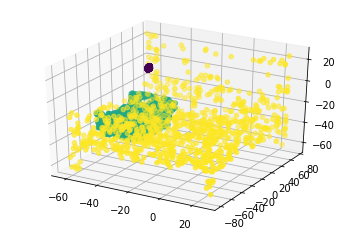

In [ ]:

IDX = 38
visualize_scene(scene_train_pc[IDX], get_point_class(scene_train_labels[IDX]))

In [ ]:
import pickle

# once loaded save the numpy arrays to pickle files to use later
pickle.dump(scene_train_pc, open("scene_trainpc.pkl", "wb"))
pickle.dump(scene_test_pc, open("scene_testpc.pkl", "wb"))
pickle.dump(scene_train_labels, open("scene_trainlabels.pkl", "wb"))
pickle.dump(scene_test_labels, open("scene_testlabels.pkl", "wb"))
# pickle.dump(class_ids, open("class_ids.pkl", "wb"))

In [ ]:
# labels = np.random.randint(0, 9, size = (10, ))

# get_tiled(one_hot(as_list(labels[3])))

In [ ]:

# print(one_hot([2]))

# some_pc = np.random.random(size= (1024, 3))
# print(some_pc)
# print(pc_transform(some_pc))


# pcs = np.random.random(size = (10, 1024, 3))
# labels = np.random.randint(0, 9, size = (10, ))

# arr1, arr2 = generate_scenes(pcs, labels, n_scenes = 5, n_objects= 3 )

# print(np.random.random(size = (10, 1024, 3)))
# print(np.random.randint(0, 9, size = 10))


In [ ]:

def test_assert():
  a = np.array([[1, 3, 5], [2, 4, 6]])
  sf = np.diag([2, 2, 2])
  print(sf)
  b = np.dot(a, sf.T)
  print(b.dtype)
  assert (b == [[2, 6, 10], [4, 8, 12]]).all()
  assert True == True
  # assert 1//2 == 1
  print([[1, 2], [3,4]] == [[1, 2], [3, 4]])
  print(b == [[2, 6, 10], [4, 8, 12]])

In [ ]:
# arr1.shape, arr2.shape

((5, 3072, 3), (5, 3072, 10))

In [ ]:
# arr2

In [ ]:
# arr1[0], arr1[3]

In [ ]:
# arr1[0].shape

(3072, 3)

In [ ]:

# arr1.min(), arr1.max()

(1.5888940975422463e-05, 2.2098433318675914)

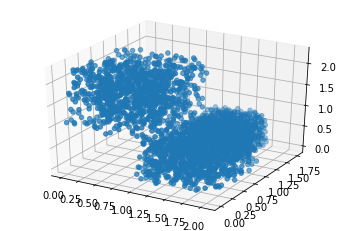

In [ ]:
# visualize_cloud(arr1[0])

In [ ]:
# arr1.shape

(5, 3072, 3)

In [ ]:
# trying ideas on hw to pick unique type of objects in a scene 

"""import pandas as pd

labels = np.random.randint(0, 10 , size = (100, ))

def get_random_index(labels):
  df = pd.DataFrame(labels, columns = ["labels"])
  df["index"] = df.index
  df.head()
  df1 = df.groupby("labels")["index"].apply(list).apply(np.random.choice)
  random_indexes = df1.sample(n=3, replace = False).tolist()
  return random_indexes

get_random_index(labels)"""

[13, 52, 83]

In [ ]:
"""import random 

def generate_scene(pc_with_labels, n_objects):
  "takes the number of objects and return a combined point cloud"
  # Do we duplicate an object in a scene? If not, random indexes have to be generated such that
  # all objects are represented once only in the scene. 

  combined_pc = []
  label_group = []
  N_RECORDS  = len(pc_with_labels)
  l = range(N_RECORDS)
  random.seed(123)
  random.shuffle(l)
  index_values  = random.sample(list(enumerate(l)), n_objects) 
  # will return the index and the value of an iterable as a tuple
  
  return combined_pc, label_group


def combine_object_pcs(pc_array, labels):

  composed_pcs_array = []
  composed_labels_array = []

  # As the number of objects in each scene will be variable, the array shape will vary between records?
  # Please ask the supervisor if we need to keep same number of objects in each scene or do we need to resample the scene

  pc_with_labels = np.vstack(pc_array, labels)
  for i in range(2000):
    with num_objects in random.randint(2, 8):
      new_pc, label_group = generate_scene(pc_with_labels, num_obejcts)
      composed_pcs_array.append(new_pc)
      composed_labels_array.append(label_group)

  return composed_pcs_array, composed_labels_array"""

In [ ]:
# some_dataset = tf.data.Dataset.from_tensor_slices((arr1, arr2))
# len(some_dataset), 
# some_dataset.take(2)

In [ ]:
# Create tensorflow data loaders from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_pc, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_pc, test_labels))

In [ ]:
# Create tensorflow data loaders from the numpy arrays
scene_train_dataset = tf.data.Dataset.from_tensor_slices((scene_train_pc, scene_train_labels))
scene_test_dataset = tf.data.Dataset.from_tensor_slices((scene_test_pc, scene_test_labels))

In [ ]:
len(train_pc)

3991

### Data Augmentation

In [ ]:
# 3. Perform data augmentation by adding noise and shuffling the dataset.
# In this step you need to fill in the utils.add_noise_and_shuffle function
# to add noise to the sampled points and shuffle the points around
batch_size = 16     # <- You can modify this value as needed
train_dataset = train_dataset.shuffle(len(train_pc)).map(add_noise_and_shuffle).batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_pc)).batch(batch_size)

## Building the model from here

### Model Building Utilities - Taken from network.py

In [ ]:
import os
import numpy as np
import tensorflow as tf
import trimesh.sample
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import pickle
import keras.backend as K

# import network
# import utils


def tnet(inputs, num_features):
    """
    This is the core t-net of the pointnet paper
    :param inputs: the input tensor
    :type inputs: tensor
    :param num_features: number of features in the tensor (3 for point cloud, N if N features)
    :type num_features: int
    :return: output tensor
    :rtype: tensor
    """

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())

    # TODO: Build the tnet with the following layers
    # Some convolutional layers (1D) - with batch normalization, RELU activation
    x = inputs
    # x = layers.Input(shape= [None, 3072, 3])(x)
    x = layers.Conv1D(filters=64, kernel_size=7, strides=2, padding="same")(x)  # produces 1D feature map, 7 kernels => 7 1D sequences
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu)(x)
    x = layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu)(x)
    x = layers.Conv1D(filters= 512, kernel_size=3, strides=2, padding="same")(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.nn.relu)(x)

    # Global max pooling
    x = layers.GlobalMaxPool1D()(x)
    # Some dense fully connected layers - with batch normalization, RELU activation
    # x = layers.Flatten()(x)
    x = layers.Dense(units=512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(units=192)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    

    # final layer with custom regularizer on the output
    # TODO: this custom regularizer needs to be defined
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=CustomRegularizer(num_features))(x)
    feat_t = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_t])


class CustomRegularizer(keras.regularizers.Regularizer):
    """
    This class implements a regularizer that makes the output to be orthogonal.
    In other words, it adds a loss |I-AA^T|^2 on the output A. Equation 2 of the paper.
    """
    def __init__(self, dim, weight=0.001):
        """
        Initializes the class
        :param dim: dimensions of the input tensor
        :type dim: int
        :param weight: weight to apply on the regularizer
        :type weight: float
        """
        self.dim = dim
        self.weight = weight

    def __call__(self, x):
        # TODO: define the custom regularizer here
        x = tf.reshape(x, (-1, self.dim, self.dim))
        # print(f"reshaped input shape: {K.shape(x)}")
        # compute the outer product and reshape it to batch size x num_features x num_features
        # outerproduct = tf.tensordot(x, tf.transpose(x), axes = [1, 2])
        outerproduct = tf.linalg.matmul(a =x, b = x, transpose_b = True)
        # print(f"outerproduct shape: {K.shape(outerproduct)}")
        outerproduct = tf.reshape(outerproduct, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[1]))
        # Compute (I-outerproduct)^2 element wise. use tf.square()
        z = tf.square( tf.eye(K.shape(x)[1]) - outerproduct)
        # Apply weight
        z = self.weight*z
        # Compute reduce sum using tf.reduce_sum()
        output = tf.reduce_sum(z)
        return output



In [ ]:
# print(arr1[:4].shape)
# x = np.random.random((4, 1800, 3))
# dim = 3
# x.shape, tf.reshape(x, (-1, 3, 3)).shape


(4, 3072, 3)


((4, 1800, 3), TensorShape([2400, 3, 3]))

In [ ]:
x1 = tnet(train_pc, 3)
x1

reshaped input shape: [3991    3    3]
outerproduct shape: [3991    3    3]


<tf.Tensor: shape=(3991, 1024, 3), dtype=float32, numpy=
array([[[-3.89466553e+01, -6.22533875e+01, -8.17519608e+01],
        [-1.23607266e+00, -4.33874321e+00, -8.89369965e+01],
        [-2.86416874e+01,  2.10205841e+01, -8.42125931e+01],
        ...,
        [ 1.75779209e+01, -5.30152512e+00, -8.42125931e+01],
        [-3.73818703e+01, -5.56361961e+01, -8.42125931e+01],
        [-2.29964638e+01, -5.44731598e+01, -7.92913284e+01]],

       [[ 5.90070188e-01,  2.06102161e+01,  9.66743565e+00],
        [ 3.92078042e-01,  8.41727543e+00,  1.29650974e+01],
        [-3.00833988e+00, -1.86815131e+00, -5.39773750e+00],
        ...,
        [-3.00833988e+00, -3.44033670e+00, -7.51126099e+00],
        [ 2.60687709e+00, -2.69889092e+00, -2.41250000e+01],
        [-7.79525089e+00, -8.32068825e+00, -2.41250000e+01]],

       [[-9.93734002e-01,  9.30820853e-02, -5.42410254e-01],
        [-8.03402066e-01,  6.08400011e+00,  3.94927335e+00],
        [-9.93734002e-01,  4.93315411e+00,  1.15713155e+00]

In [ ]:
# x = np.random.random((4, 1024, 3))
# x1 = tnet(x, 3)
# x1

In [ ]:

def pointnet_classifier(num_points_per_cloud, num_classes):
    """
    This is the object classifier version of PointNet
    :param inputs: input point clouds tensor
    :type inputs: tensor
    :param num_classes: number of classes
    :type num_classes: int
    :return: the predicted labels
    :rtype: tensor
    """
    # TODO: build the network using the following layers
    # apply tnet to the input data
    inputs = keras.Input(shape=(num_points_per_cloud, 3))
    f_3 = tnet(inputs, 3)
    # extract features using some Convolutional Layers - with batch normalization and RELU activation
    x = layers.Conv1D(filters= 32, kernel_size= 3, strides =1, activation= "relu")(f_3)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 64, kernel_size= 2, strides =1, activation= "relu")(x)
    x = layers.BatchNormalization()(x)
    # apply tnet on the feature vector
    f_64 = tnet(x, 64)  # output of this layer to be used in segmentation model
    # extract features using some Convolutional Layers - with batch normalization and RELU activation
    x = layers.Conv1D(filters= 128, kernel_size= 2, strides =1, activation= "relu")(f_64)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 256, kernel_size= 2, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 512, kernel_size= 2, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # apply 1D global max pooling
    global_features = layers.GlobalMaxPool1D()(x)  # output of this layer to be used in segmentation model
    # Add a few dense layers with dropout between the layers
    x = layers.Dense(units = 128, activation = "relu")(global_features)
    x = layers.Dense(units = 64, activation = "relu")(x)
    # Finally predict classes using a dense layer with a softmax activation
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")

    return model



def pointnet_segmenter(num_points_per_cloud, labels):
    """
    This is the semantic segmentation version of Pointnet
    :param inputs: input point cloud
    :type inputs: tensor
    :param labels: labels for each point of the point cloud
    :type labels: tensor
    :return: predicted labels for each point of the point cloud
    :rtype: tensor
    """
    # TODO: build the network using the following layers
    # apply tnet to the input data
    inputs = keras.Input(shape=(num_points_per_cloud, 3))
    f_3 = tnet(inputs, 3)
    # extract features using some Convolutional Layers - with batch normalization and RELU activation
    x = layers.Conv1D(filters= 32, kernel_size= 3, strides =1, activation= "relu")(f_3)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 64, kernel_size= 3, strides =1, activation= "relu")(x)
    x = layers.BatchNormalization()(x)
    # apply tnet on the feature vector
    f_64 = tnet(x, 64)
    # extract features using some Convolutional Layers - with batch normalization and RELU activation
    x = layers.Conv1D(filters= 128, kernel_size= 2, strides =1, activation= "relu")(f_64)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 256, kernel_size= 2, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 1024, kernel_size= 2, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # apply 1D global max pooling
    global_features = layers.GlobalMaxPool1D()(x)
    # concatenate these features with the earlier features (f)
    # you can also use skip connections if you like
    z = layers.concatenate([f_64, global_features])
    # extract features using some Convolutional Layers - with batch normalization and RELU activation
    x = layers.Conv1D(filters= 512, kernel_size= 3, strides =1, activation= "relu")(z)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 256, kernel_size= 3, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters= 128, kernel_size= 3, strides =1, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation = "relu")(x)
    outputs = layers.Dense(128, activation = "softmax")(x)
    # return the output

    model = keras.Model(inputs=inputs, outputs=outputs, name="segpointnet")

    return model

### Classification Model

In [ ]:
# 1. Fill in the skeleton code given in the network.py file
num_points_per_cloud = 1024

model  = pointnet_classifier(num_points_per_cloud, num_classes=10)
model.summary()
# outputs = network.pointnet_segmenter(inputs, train_labels)

model.compile(
      loss="mse",     # <- choose a suitable loss function
      optimizer=keras.optimizers.Adam(learning_rate=0.001),      # <- you may modify this if you like
      metrics=["accuracy"]   # <- choose a suitable metric, https://www.tensorflow.org/api_docs/python/tf/keras/metrics
  )

# mirrored_strategy = tf.distribute.MirroredStrategy()
# with mirrored_strategy.scope():
#   # build the network and visualize its architecture
#   # model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
#   # 2. Set the loss function, optimizer and metrics to print
#   model.compile(
#       loss="categorical_crossentropy",     # <- choose a suitable loss function
#       optimizer=keras.optimizers.Adam(learning_rate=0.001),      # <- you may modify this if you like
#       metrics=["accuracy"]   # <- choose a suitable metric, https://www.tensorflow.org/api_docs/python/tf/keras/metrics
#   )


Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 1024, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_355 (Conv1D)             (None, 512, 64)      1408        input_59[0][0]                   
__________________________________________________________________________________________________
batch_normalization_472 (BatchN (None, 512, 64)      256         conv1d_355[0][0]                 
__________________________________________________________________________________________________
activation_349 (Activation)     (None, 512, 64)      0           batch_normalization_472[0][0]    
___________________________________________________________________________________________

In [ ]:
# train the network
num_epochs = 25     # <- change this value as needed
model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/25
250/250 [==============================] - 15s 46ms/step - loss: 18.5516 - accuracy: 0.0847 - val_loss: 24.8715 - val_accuracy: 0.1013
Epoch 2/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5329 - accuracy: 0.0872 - val_loss: 24.6818 - val_accuracy: 0.1068
Epoch 3/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5327 - accuracy: 0.1416 - val_loss: 25.3810 - val_accuracy: 0.0969
Epoch 4/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5327 - accuracy: 0.1288 - val_loss: 28.3466 - val_accuracy: 0.0969
Epoch 5/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5326 - accuracy: 0.0506 - val_loss: 24.9783 - val_accuracy: 0.0947
Epoch 6/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5326 - accuracy: 0.0496 - val_loss: 24.7194 - val_accuracy: 0.0969
Epoch 7/25
250/250 [==============================] - 11s 44ms/step - loss: 18.5326 - accuracy: 0.0504 - val_loss: 26.7710 -

In [ ]:

# visualize results
data = test_dataset.take(1)
point_clouds, labels = list(data)[0]  # this is one batch of data

# predict labels using the model
preds = model.predict(point_clouds)
preds = tf.math.argmax(preds, -1)


In [ ]:

# 3. Display some clouds using matplotlib scatter plot along with true and predicted labels

# 4. Display a confusion matrix

### Segmentation Model

In [ ]:
num_points_per_cloud = 3072
# inputs = keras.Input(shape=(num_points_per_cloud, 3))
# outputs = pointnet_classifier(inputs, num_classes=10)
outputs = pointnet_segmenter(num_points_per_cloud, scene_train_labels)
model = keras.Model(inputs=inputs, outputs=outputs, name="segmentnet")
model.summary()

reshaped input shape: Tensor("dense_242/ActivityRegularizer/Shape:0", shape=(3,), dtype=int32)
outerproduct shape: Tensor("dense_242/ActivityRegularizer/Shape_1:0", shape=(3,), dtype=int32)
reshaped input shape: Tensor("dense_245/ActivityRegularizer/Shape:0", shape=(3,), dtype=int32)
outerproduct shape: Tensor("dense_245/ActivityRegularizer/Shape_1:0", shape=(3,), dtype=int32)


ValueError: ignored

In [ ]:

model.compile(loss = "categorical_crossentropy", optimizer = tf.optimizers.Adam, metrics = ["accuracy"])

In [ ]:
N_EPOCHS = 5
model.fit(scene_train_dataset
          epochs = N_EPOCHS,
          verbose = 1,
          validation_data = scene_test_dataset)